# imports

In [1]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import partial, reduce
from typing import DefaultDict, Tuple, List, Dict
from torch import nn
import pandas as pd
from tqdm import tqdm
import pickle
import nlp_utils # our utils

/home/dcor/roeyron/miniconda3/envs/patchscopes/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# !nvidia-smi

In [2]:
cache_dir = nlp_utils.get_cache_dir()
device = "cuda" if torch.cuda.is_available() else "cpu"

# load Llava

In [3]:
model_name = "llava-hf/llava-v1.6-mistral-7b-hf"

processor = LlavaNextProcessor.from_pretrained(model_name, cache_dir=cache_dir)
model = LlavaNextForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch.float16, cache_dir=cache_dir)
model.generation_config.pad_token_id = processor.tokenizer.pad_token_id

model = model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# load data

In [4]:
df_data = nlp_utils.get_animals_data_df(limit_per_class=50)
print(len(df_data))
df_data.head()

NameError: name 'nlp_utils' is not defined

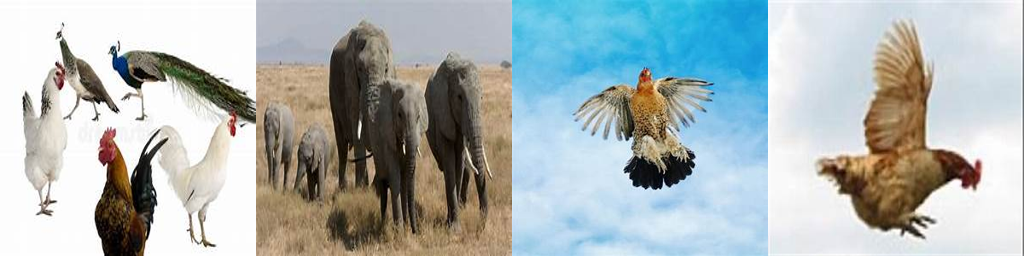

In [6]:
ids = np.random.randint(len(df_data), size=4)
image_paths = [df_data.image_path.iloc[i] for i in ids]
images = [Image.open(p) for p in image_paths]
Image.fromarray(np.concatenate([img.resize((256, 256)) for img in images], axis=1))

# run model on data

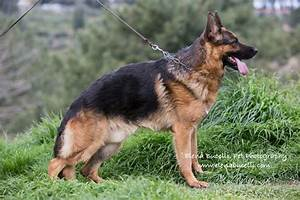

In [16]:
image1 = Image.open(df_data.image_path[22])
image1

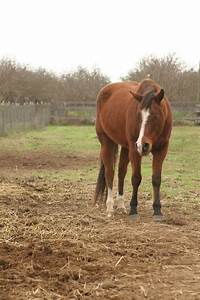

In [17]:
image2 = Image.open(df_data.image_path[66])
image2

In [20]:
question = 'What is common between these two images'
question = 'Who is the CEO of google?'
prompt = f"[INST] <image>\n{question} [/INST]"
inputs = processor(prompt, image2, return_tensors="pt").to(device)
output = model.generate(**inputs, max_new_tokens=100, output_hidden_states=True, return_dict_in_generate=True)
result_text = processor.decode(output['sequences'][0], skip_special_tokens=True)
result_text = result_text.split(prompt.replace('<image>', ' '))[1].strip()
print(f'Q: {question};\nA: {result_text}')

Q: Who is the CEO of google?;
A: The CEO of Google is Sundar Pichai. He has been the CEO since October 2015.


# extract number of layers

In [9]:
all_module_names = [name for name, _ in model.named_modules()]
# print(all_module_names[:5])
lang_model_related_layers = [module_name for module_name in all_module_names if 'language_model.model.layers.' in module_name]
layers = list(set([e.split('language_model.model.layers.')[1].split('.')[0] for e in lang_model_related_layers]))
n_layers = max([int(e) for e in layers])
n_layers

31

# Save hidden states using my hooks

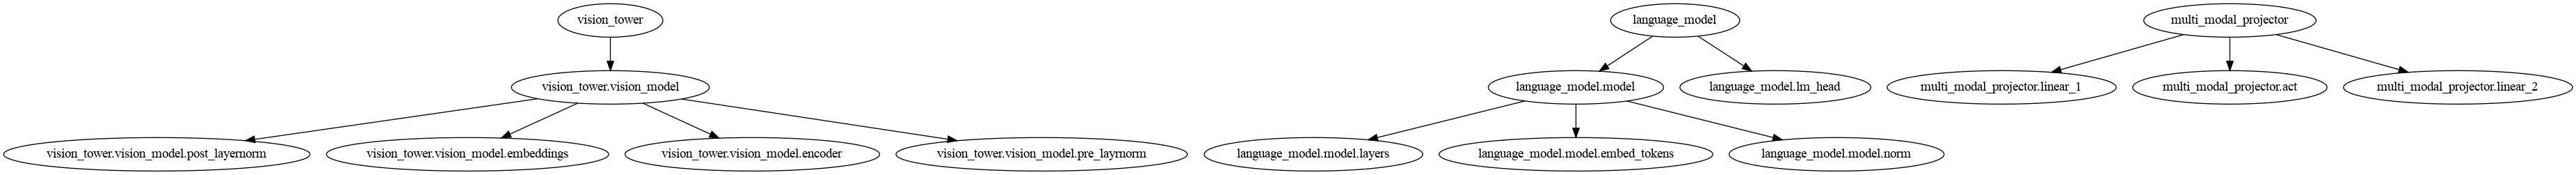

In [10]:
import graphviz
from PIL import Image

def plot_model_graph(nodes, max_depth=3):
    dot = graphviz.Digraph()

    def add_edges(dot, nodes, max_depth=None):
        edges = set()
        for node in nodes:
            parts = node.split('.')
            for i in range(1, len(parts)):
                if max_depth is not None and i >= max_depth:
                    break
                parent = '.'.join(parts[:i])
                child = '.'.join(parts[:i+1])
                edges.add((parent, child))
        for edge in edges:
            dot.edge(edge[0], edge[1])
    
    def generate_graph(nodes, max_depth=None):
        dot = graphviz.Digraph()
        add_edges(dot, nodes, max_depth)
        return dot
    
    graph_with_depth = generate_graph(nodes, max_depth)
    file_path_depth = "./hierarchical_structure_graph_depth"
    graph_with_depth.render(file_path_depth, format='png', cleanup=True)
    img_path = file_path_depth +'.png'
    display(Image.open(img_path))

plot_model_graph(all_module_names)

In [11]:
# layer_f_string = 'language_model.model.layers.{0}'
# layer_f_string = 'language_model.model.layers.{0}.self_attn'
# layer_f_string = 'language_model.model.layers.{0}.self_attn.q_proj'
# layer_f_string = 'language_model.model.layers.{0}.self_attn.k_proj'
# layer_f_string = 'language_model.model.layers.{0}.self_attn.v_proj'
# layer_f_string = 'language_model.model.layers.{0}.self_attn.o_proj'
# layer_f_string = 'language_model.model.layers.{0}.self_attn.rotary_emb'
# layer_f_string = 'language_model.model.layers.{0}.mlp'
# layer_f_string = 'language_model.model.layers.{0}.mlp.gate_proj'
# layer_f_string = 'language_model.model.layers.{0}.mlp.up_proj'
# layer_f_string = 'language_model.model.layers.{0}.mlp.down_proj'
# layer_f_string = 'language_model.model.layers.{0}.mlp.act_fn'
# layer_f_string = 'language_model.model.layers.{0}.input_layernorm'
layer_f_string = 'language_model.model.layers.{0}.post_attention_layernorm'

print('layer_f_string:', layer_f_string, end=2*'\n')


layer_names = [layer_f_string.format(layer_i) for layer_i in range(n_layers)] 
layer_names[:5]

layer_f_string: language_model.model.layers.{0}.post_attention_layernorm


['language_model.model.layers.0.post_attention_layernorm',
 'language_model.model.layers.1.post_attention_layernorm',
 'language_model.model.layers.2.post_attention_layernorm',
 'language_model.model.layers.3.post_attention_layernorm',
 'language_model.model.layers.4.post_attention_layernorm']

In [12]:
def save_activations(
        activations: DefaultDict,
        name: str,
        module: nn.Module,
        inp: Tuple,
        out: torch.Tensor) -> None:
    if name == 'language_model.model.layers.2.post_attention_layernorm':
        print('hello', len(activations[name]))
    activations[name].append(out.detach().cpu())

def get_module_by_name(module, access_string):
    names = access_string.split(sep='.')
    return reduce(getattr, names, module)

def set_hooks(model, activations_dict, module_names_to_hook):
    handles = []
    for name in module_names_to_hook:
        print('register_forward_hook to', name)
        module = get_module_by_name(model, name)
        hook = partial(save_activations, activations_dict, name)
        handle = module.register_forward_hook(hook)
        handles.append(handle)
    return handles

def remove_hooks(handles):
    for handle in handles:
        handle.remove()

def get_activations(activations_dict, layer_i):
    layer_str = layer_f_string.format(layer_i)
    activations = activations_dict[layer_str]
    return activations


# activations_dict = defaultdict(list)
# handles = set_hooks(model, activations_dict, layer_names)

In [13]:
# remove_hooks(handles)

# get hidden states directly from the model using output_hidden_states

In [14]:
question = 'What kind of animal is in the image? answer shortly'
prompt = f"[INST] <image>\n{question} [/INST]"
inputs = processor(prompt, image, return_tensors="pt").to(device)
output = model.generate(**inputs, max_new_tokens=100, output_hidden_states=True, return_dict_in_generate=True)
result_text = processor.decode(output['sequences'][0], skip_special_tokens=True)
result_text = result_text.split(prompt.replace('<image>', ' '))[1].strip()
print(f'Q: {question};\nA: {result_text}')
print('# input tokens:', inputs['input_ids'].shape[1])
print('# output tokens:', output['sequences'].shape[1])

Q: What kind of animal is in the image? answer shortly;
A: Horse
# input tokens: 23
# output tokens: 26


In [15]:
"""
====================================
     hidden_states structure
====================================

time0
    layer_0
        (1, 2182, 4096)  # for the first response we are getting the hidden states of all positions up to 2182
    ....
    layer_32
        (1, 2182, 4096)
time1
    layer_0
        (1, 1, 4096)
    ....
    layer_32
        (1, 1, 4096)
...
timeT
    layer_0
        (1, 1, 4096)
    ....
    layer_32
        (1, 1, 4096)   
         
"""
print('')

In [16]:
hidden_states = output['hidden_states']

time = 0       # 0 < time < seuqnce_length
layer = -1     # 0 < layer < 32
sample = 0     # batch size is 1
token_loc = 0  # 0 < token_loc <= time < seuqnce_length

embd = hidden_states[time][layer][sample]
embd.shape

torch.Size([998, 4096])

# Project hidden states on the output embedding matrix

In [78]:
hidden_states

((array([[[-4.547e-03,  3.529e-04, -5.157e-03, ...,  4.077e-05,
           -1.030e-03, -1.278e-04],
          [-4.486e-03, -5.198e-05, -1.823e-03, ...,  2.413e-04,
            4.059e-03,  4.368e-04],
          [ 1.507e-04,  3.414e-04, -2.426e-03, ..., -2.579e-03,
            3.250e-03, -2.869e-03],
          ...,
          [-8.049e-04,  1.251e-03, -6.485e-04, ...,  3.567e-04,
           -4.181e-03,  1.869e-04],
          [ 1.507e-04,  3.414e-04, -2.426e-03, ..., -2.579e-03,
            3.250e-03, -2.869e-03],
          [-4.028e-03, -1.808e-03,  3.738e-03, ..., -2.184e-04,
           -1.038e-03,  3.296e-03]]], dtype=float16),
  array([[[-1.656e-03,  1.913e-03, -1.741e-01, ..., -1.103e-03,
           -4.215e-03,  2.209e-03],
          [ 3.471e-03,  1.227e-04,  4.139e-03, ...,  1.333e-03,
            4.890e-03,  2.718e-03],
          [ 3.349e-03, -5.363e-03, -6.760e-03, ..., -2.697e-03,
            5.959e-03, -2.422e-03],
          ...,
          [-1.330e-03, -3.471e-03,  1.881e-03, ..., 

In [75]:
processor.tokenizer(['water'])

{'input_ids': [[1, 2130]], 'attention_mask': [[1, 1]]}

In [77]:
W[2130].shape

torch.Size([4096])

In [17]:
time = 0
sample = 0
token_loc = -1
token_loc = -1

W = model.get_output_embeddings().weight  # the Unembedding matrix (#tokens, embedding_dim) = (32000, 4096)

for layer in range(28, n_layers+1):
    print('layer -', layer)
    embd = hidden_states[time][layer][sample][token_loc]

    logits_l = W @ embd
    closest_inds = torch.argsort(logits_l, descending=True)[:5]
    for i, ind in enumerate(closest_inds):
        most_probable_token = processor.decode(ind)
        print(f'rank {i} hidden state is closest to: {most_probable_token}')

layer - 28
rank 0 hidden state is closest to: horse
rank 1 hidden state is closest to: horses
rank 2 hidden state is closest to: Horse
rank 3 hidden state is closest to: hor
rank 4 hidden state is closest to: equ
layer - 29
rank 0 hidden state is closest to: horse
rank 1 hidden state is closest to: horses
rank 2 hidden state is closest to: Horse
rank 3 hidden state is closest to: hor
rank 4 hidden state is closest to: hors
layer - 30
rank 0 hidden state is closest to: horse
rank 1 hidden state is closest to: horses
rank 2 hidden state is closest to: Horse
rank 3 hidden state is closest to: hor
rank 4 hidden state is closest to: H
layer - 31
rank 0 hidden state is closest to: Horse
rank 1 hidden state is closest to: horse
rank 2 hidden state is closest to: H
rank 3 hidden state is closest to: horses
rank 4 hidden state is closest to: The


# store hidden states of the entire dataset

In [79]:

ddl_inference = defaultdict(list)
for _, row in tqdm(df_data.iterrows(), total=len(df_data)):
    image = Image.open(row.image_path)
    question = 'Who is the CEO of google?'
    prompt = f"[INST] <image>\n{question} [/INST]"
    inputs = processor(prompt, image, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_new_tokens=100, output_hidden_states=True, return_dict_in_generate=True)
    # result_text = processor.decode(output['sequences'][0], skip_special_tokens=False)
    # result_text = result_text.split(prompt)[-1].strip()
    hidden_states = output['hidden_states']
    hidden_states = tuple(tuple(t.detach().cpu().numpy() for t in inner_tuple) for inner_tuple in hidden_states)
    input_ids = list(inputs['input_ids'][0].detach().cpu().numpy())      # [1, 733, 16289
    output_ids = list(output['sequences'][0].detach().cpu().numpy())     # [1, 733, 16289, ...

    ddl_inference['hidden_states'].append(hidden_states)
    ddl_inference['input_ids'].append(input_ids)
    ddl_inference['output_ids'].append(output_ids)
    

100%|██████████| 500/500 [11:25<00:00,  1.37s/it]


# train classifier on different hidden states

In [19]:
def get_tokens(ids: List[int]):
    return [processor.tokenizer.decode(i) for i in ids]


def get_text(ids: List[int]):
    return processor.decode(ids)  


def print_data(input_ids, output_ids, hidden_states):
    input_ids                               # [1, 733, 16289
    input_tokens = get_tokens(input_ids)    # ['<s>', '[', 'INST', ..
    input_text = get_text(input_ids)        # '<s> [INST...
    
    output_ids                              # [1, 733, 16289, ...
    output_tokens = get_tokens(output_ids)  # ['<s>', '[', 'INST', ..
    output_text = get_text(output_ids)      # '<s> [INST...
    
    assert input_ids == output_ids[:len(input_ids)]
    assert input_tokens == output_tokens[:len(input_tokens)]
    assert input_text == output_text[:len(input_text)]
    assert len(hidden_states) == len(output_ids) - len(input_ids)
    
    hs = hidden_states[time][layer][sample][location]
    
    plt.figure()
    plt.imshow(image)
    plt.show()
    
    print(hs.shape)
    # hs = hs.detach().cpu()
    logits_l = W @ hs
    closest_inds = torch.argsort(logits_l, descending=True)[:1]
    for i, ind in enumerate(closest_inds):
        most_probable_token = processor.decode(ind)
        print(f'rank {i} hidden state is closest to: {most_probable_token}')

In [20]:
print()

In [80]:
# import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score


class_names = sorted(list(df_data.class_name.unique()))
labels = df_data.class_name.apply(lambda name: class_names.index(name)).to_list()
y = labels


# define grid
token_locs = list(range(-len(input_ids), 0))
token_locs = [-3]
layers = list(range(n_layers))
layers = list(range(n_layers-4, n_layers))

pbar = tqdm(total=len(token_locs) * len(layers))

time = 0
sample = 0

ddl = defaultdict(list)
for token_loc in token_locs:
    for layer in layers:
        X = np.array([hs[time][layer][sample][token_loc] for hs in ddl_inference['hidden_states']])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        classifier = MLPClassifier(max_iter=200)
        
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
    
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)

        ddl['token_loc'].append(token_loc)
        ddl['layer'].append(layer)
        ddl['accuracy'].append(accuracy)
        pbar.update(1)
    
        # print("Accuracy:", accuracy)
        # print("Classification Report:\n", report)
pbar.close()

  0%|          | 0/4 [00:00<?, ?it/s]/home/dcor/roeyron/miniconda3/envs/patchscopes/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 25%|██▌       | 1/4 [00:03<00:11,  3.75s/it]/home/dcor/roeyron/miniconda3/envs/patchscopes/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 50%|█████     | 2/4 [00:07<00:07,  3.77s/it]/home/dcor/roeyron/miniconda3/envs/patchscopes/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 75%|███████▌  | 3/4 [00:11<00:03,  3.78s/it]/home/dcor/roeyron/miniconda3/env

In [81]:
df_acc = pd.DataFrame(ddl)
df_acc

,token_loc,layer,accuracy
0,-3,27,0.88
1,-3,28,0.89
2,-3,29,0.90
3,-3,30,0.89


In [36]:
# with open('./training_results.pickle', 'wb') as f:
#     pickle.dump(ddl, f)

with open('./training_results.pickle', 'rb') as f:
    ddl_loaded = pickle.load(f)

In [37]:
df_acc = pd.DataFrame(ddl_loaded)
df_acc

,token_loc,layer,accuracy
0,-23,0,0.69
1,-23,1,0.69
2,-23,2,0.68
3,-23,3,0.70
4,-23,4,0.67
...,...,...,...
708,-1,26,0.99
709,-1,27,0.99
710,-1,28,0.99
711,-1,29,0.99


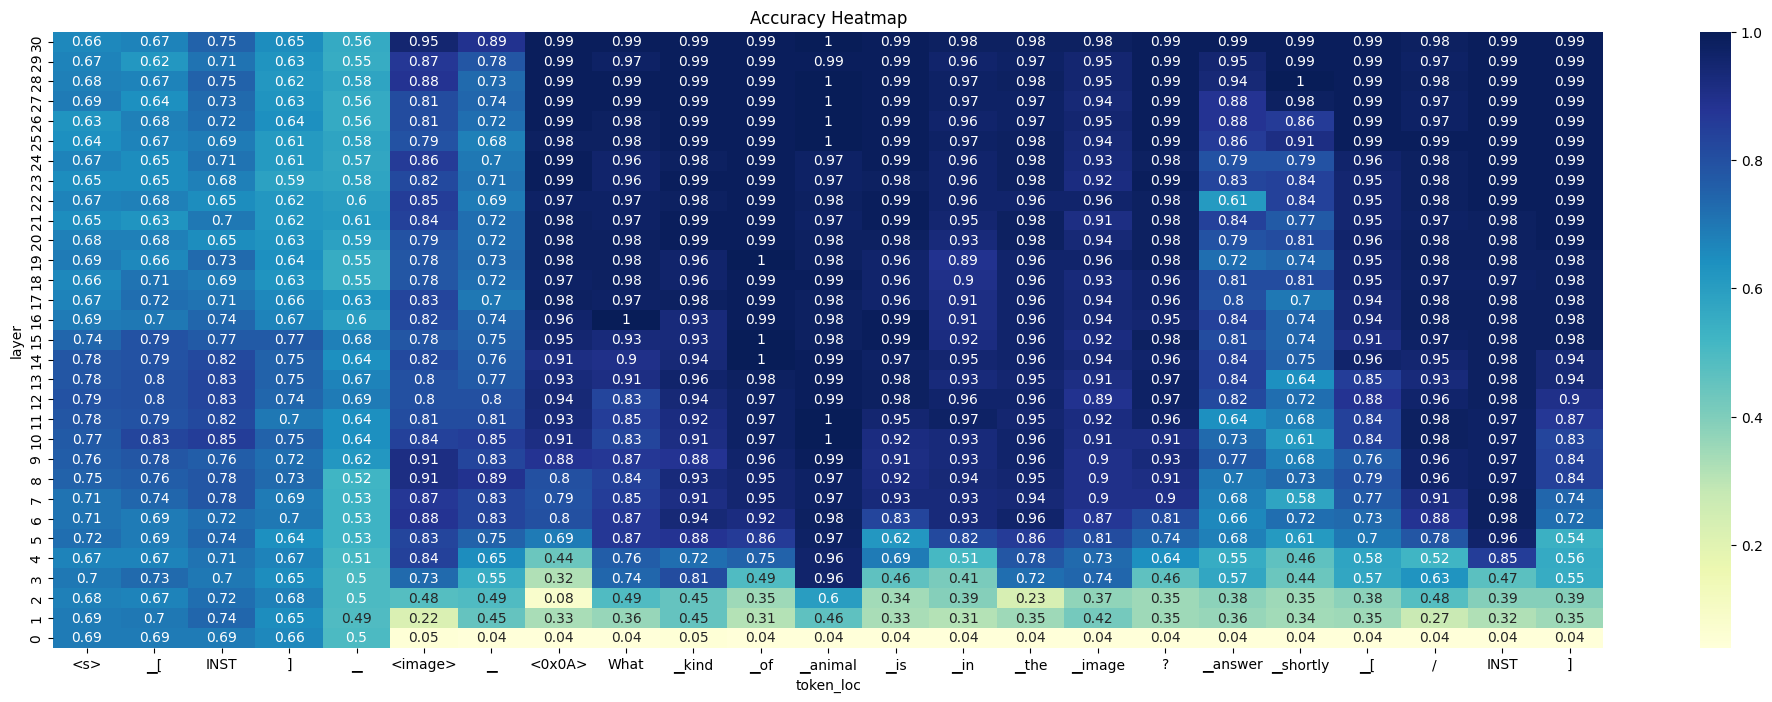

In [41]:
token_locs = df_acc.token_loc.unique()
token_ids = np.array(input_ids)[token_locs]
tokens = processor.tokenizer.convert_ids_to_tokens(token_ids)

import seaborn as sns
plt.figure(figsize=(25, 8))
heatmap_data = df_acc.pivot(columns=["token_loc"], index="layer", values="accuracy")
ax = sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", )
ax.invert_yaxis()
plt.title('Accuracy Heatmap')
plt.xticks(np.array(range(len(tokens)))+0.5, tokens)

plt.show()

In [47]:
"Answer the question using a single word or a phrase"

'Answer the question using a single word or a phrase'

In [49]:
df_acc

,token_loc,layer,accuracy
0,-23,0,0.69
1,-23,1,0.69
2,-23,2,0.68
3,-23,3,0.70
4,-23,4,0.67
...,...,...,...
708,-1,26,0.99
709,-1,27,0.99
710,-1,28,0.99
711,-1,29,0.99


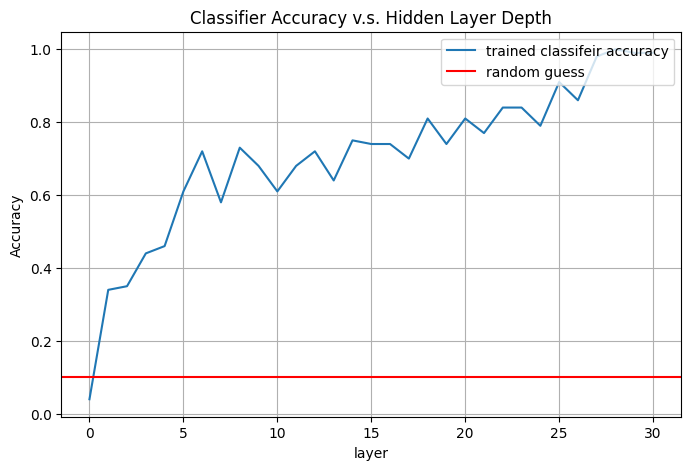

In [67]:
df_temp = df_acc[df_acc.token_loc == -5]
x = df_temp.layer
y = df_temp.accuracy


plt.figure(figsize=(8, 5))
plt.title('Classifier Accuracy v.s. Hidden Layer Depth')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('layer')
plt.plot(x, y, label='trained classifeir accuracy')
plt.axhline(1 / len(class_names), label='random guess', c='red')
plt.legend(loc='upper right')
plt.show()